In [1]:
import torch; 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

/home/tianjc/anaconda3/envs/tian_vae/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

print("Loading MNIST dataset...")
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('~/datasets', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

Loading MNIST dataset...


In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.linear1(z))
        return self.linear2(z)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        x_hat = F.relu(self.linear1(z))
        x_hat = torch.sigmoid(self.linear2(x_hat))
        return x_hat.reshape((-1, 1, 28, 28))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [7]:
autoencoder = Autoencoder(latent_dims=2).to(device) # GPU
autoencoder = train(autoencoder, data)

epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
epoch: 20/20


In [12]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # print(i,x,y)
        z = autoencoder.encoder(x.to(device))
        print(z.shape)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([1

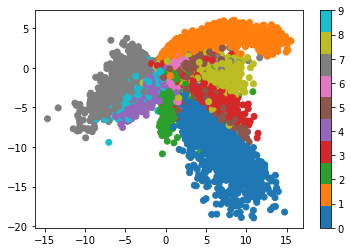

In [13]:
plot_latent(autoencoder, data)

In [26]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

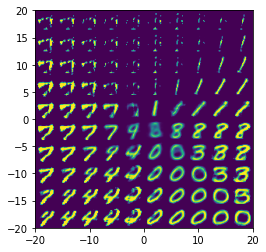

In [30]:
plot_reconstructed(autoencoder, r0=(-20, 20), r1=(-20, 20), n=10)

In [31]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        
        z = mu + sigma*torch.randn_like(sigma)
        self.kl = 0.5*(sigma**2 + mu**2 - torch.log(sigma) - 1).sum()

        return z

In [32]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        # 所以vae和ae用的是一样的decoder，但是encoder变了是吧
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)